<a href="https://colab.research.google.com/github/Minhhhh29/AI_1/blob/main/BTVN1_AI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#B1
import os
import cv2
import numpy as np
import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import kagglehub

# Tải dataset từ KaggleHub
path = kagglehub.dataset_download('shyambhu/hands-and-palm-images-dataset')

# Giải nén nếu cần
for file in os.listdir(path):
    if file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(path, file), 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f"Đã giải nén: {file}")

# Tìm thư mục chứa ảnh
def find_data_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        if any(file.lower().endswith(('.jpg', '.jpeg', '.png')) for file in files):
            return root
    return None

data_dir = find_data_folder(path)
print("Thư mục chứa ảnh:", data_dir)

img_size = 100
X = []
y = []

# Kiểm tra xem có thư mục con không
has_subfolders = any(os.path.isdir(os.path.join(data_dir, d)) for d in os.listdir(data_dir))

if has_subfolders:
    print("Có thư mục con, dùng tên thư mục làm nhãn.")
    for label in os.listdir(data_dir):
        person_dir = os.path.join(data_dir, label)
        if os.path.isdir(person_dir):
            for img_file in os.listdir(person_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(person_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    img = cv2.resize(img, (img_size, img_size))
                    img = img.astype('float32') / 255.0
                    X.append(img)
                    y.append(label.lower())  # Đảm bảo đồng bộ tên nhãn
else:
    print("Không có thư mục con, sẽ phân loại theo tên file.")
    for img_file in os.listdir(data_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(data_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype('float32') / 255.0
            X.append(img)

            # Gán nhãn từ tên file
            fname = img_file.lower()
            if "palm" in fname:
                y.append("palms")
            elif "hand" in fname:
                y.append("hands")
            else:
                y.append("unknown")  # hoặc dùng continue để bỏ qua ảnh không xác định

# Kiểm tra dữ liệu
print("Tổng ảnh đọc được:", len(X))
print("Số lượng nhãn:", len(set(y)))
print("Danh sách nhãn:", set(y))

# Xử lý nếu không có dữ liệu
if len(X) == 0 or len(y) == 0:
    raise ValueError("Không có dữ liệu ảnh hoặc nhãn.")

# Chuyển X thành mảng NumPy và reshape
X = np.array(X).reshape(-1, img_size, img_size, 1)

# Mã hóa nhãn
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tách train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

print("Load dữ liệu hoàn tất!")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)





Thư mục chứa ảnh: /kaggle/input/hands-and-palm-images-dataset/Hands/Hands
Không có thư mục con, sẽ phân loại theo tên file.
Tổng ảnh đọc được: 11076
Số lượng nhãn: 1
Danh sách nhãn: {'hands'}
Load dữ liệu hoàn tất!
X_train: (8860, 100, 100, 1)
y_train: (8860, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Flatten(input_shape=(img_size, img_size, 1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,281 (9.89 MB)

 Trainable params: 2,593,281 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Tạo dữ liệu mẫu nhị phân
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Xây dựng mô hình
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # dùng sigmoid cho binary classification
])

# Compile mô hình
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=30,
    validation_data=(X_val, y_val)
)


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7858 - loss: 0.4640 - val_accuracy: 0.9015 - val_loss: 0.2586
Epoch 2/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9006 - loss: 0.2720 - val_accuracy: 0.9205 - val_loss: 0.2304
Epoch 3/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9135 - loss: 0.2584 - val_accuracy: 0.9275 - val_loss: 0.2162
Epoch 4/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9234 - loss: 0.2416 - val_accuracy: 0.9305 - val_loss: 0.2098
Epoch 5/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9363 - loss: 0.2129 - val_accuracy: 0.9315 - val_loss: 0.2086
Epoch 6/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9354 - loss: 0.2188 - val_accuracy: 0.9325 - val_loss: 0.2065
Epoch 7/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9370 - loss: 0.2144 - val_accuracy: 0.9320 - val_loss: 0.2027
Epoch 8/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9345 - loss: 0.2239 - val_accuracy: 0.9365 - val_

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
X = np.random.rand(1000, 100, 100, 1)  # 1000 ảnh grayscale
y = np.random.randint(0, 2, 1000)      # Nhãn: 0 hoặc 1

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # vì là bài toán phân loại nhị phân
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
accuracy = model.evaluate(X_test, y_test)
print('Test loss:', accuracy[0])
print('Test accuracy:', accuracy[1])


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 625ms/step - accuracy: 0.4650 - loss: 1.1096 - val_accuracy: 0.5125 - val_loss: 0.6935
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - accuracy: 0.4869 - loss: 0.6970 - val_accuracy: 0.4875 - val_loss: 0.6981
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - accuracy: 0.4889 - loss: 0.6967 - val_accuracy: 0.4875 - val_loss: 0.6939
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.5070 - loss: 0.6914 - val_accuracy: 0.4875 - val_loss: 0.7099
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - accuracy: 0.5432 - loss: 0.6896 - val_accuracy: 0.5125 - val_loss: 0.6932
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4053 - loss: 0.6954 
Test loss: 0.6942621469497681
Test accuracy: 0.46000000834465027


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


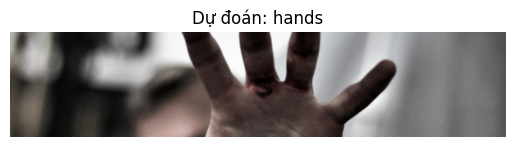

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def predict_palm(image_path):
    # Kiểm tra ảnh có tồn tại không
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(" Không thể đọc ảnh. Vui lòng kiểm tra lại đường dẫn:", image_path)
        return

    # Resize ảnh theo kích thước đầu vào của model
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = img.reshape(1, img_size, img_size, 1)  # Input shape: (1, img_size, img_size, 1)

    # Dự đoán
    prediction = model.predict(img)
    predicted_class = le.inverse_transform([np.argmax(prediction)])

    # Hiển thị ảnh và kết quả
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))  # Hiển thị ảnh màu
    plt.title(f"Dự đoán: {predicted_class[0]}")
    plt.axis('off')
    plt.show()

# Gọi hàm để dự đoán
predict_palm('/content/sample_data/dataset-cover.jpg')
import cv2
import numpy as np
from matplotlib import pyplot as plt

def predict_palm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = img.reshape(1, img_size, img_size, 1)  # đúng shape input

    prediction = model.predict(img)
    predicted_class = le.inverse_transform([np.argmax(prediction)])

    # Hiển thị ảnh và kết quả
    plt.title(f"Dự đoán: {predicted_class[0]}")
    plt.axis('off')
    plt.show()